In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import cmweather

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
ds = xr.open_dataset('/home/alfonso/Downloads/CAMP2Ex-APR3-L2Znad_P3B_20190916_R2.nc')

In [3]:
origin = f'{ds.time.long_name[14:]}'
ds['Time'] = pd.to_datetime(ds.time ,unit='s', origin=origin)
ds['Alt_range'] = ds.alt_range.values / 1000

In [4]:
ds = xr.open_dataset('/home/alfonso/Downloads/CAMP2Ex-APR3-L2Znad_P3B_20190916_R2.nc')
time = '2019-09-16 03:21:42'
top = 4.4
bottom = 0.2
origin = f'{ds.time.long_name[14:]}'
ds['Time'] = pd.to_datetime(ds.time, unit='s', origin=origin)
ds['Alt_range'] = ds.alt_range.values / 1000
ds = ds.sel(Alt_range=slice(bottom, 8))

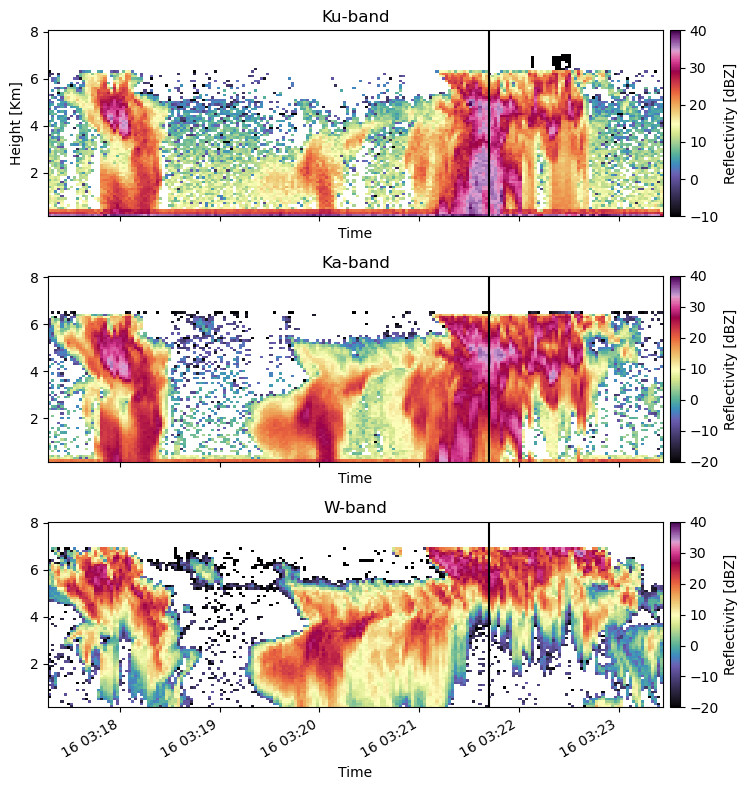

In [5]:
fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

sc = ds['lores_zhh14'].isel(Time=range(8100, 8300)).T.plot(vmin=-10, vmax=40, cmap='ChaseSpectral', ax=ax, add_colorbar=False)
sc1 = ds['lores_zhh35'].isel(Time=range(8100, 8300)).T.plot(vmin=-20, vmax=40, cmap='ChaseSpectral', ax=ax1, add_colorbar=False)
sc2 = ds['hi2lo_z95n'].isel(Time=range(8100, 8300)).T.plot(vmin=-20, vmax=40, cmap='ChaseSpectral', ax=ax2, add_colorbar=False)

ax.axvline(ds.Time.sel(Time=time).isel(Time=0).values, 0, 150, c='k')
ax.set_title('Ku-band')
ax.set_ylabel("Height [Km]")

ax1.axvline(ds.Time.sel(Time=time).isel(Time=0).values, 0, 150, c='k')
ax1.set_title('Ka-band')
ax1.set_ylabel("")
ax2.axvline(ds.Time.sel(Time=time).isel(Time=0).values, 0, 150, c='k')
ax2.set_title('W-band')
ax2.set_ylabel("")

x_ku = ds['lores_zhh14'].sel(Time=time).isel(Time=0)
x_ka = ds['lores_zhh35'].sel(Time=time).isel(Time=0)
x_w = ds['hi2lo_z95n'].sel(Time=time).isel(Time=0)


plt.tight_layout()
fig.colorbar(sc, ax=ax, pad=0.01, label='Reflectivity [dBZ]')
fig.colorbar(sc1, ax=ax1, pad=0.01, label='Reflectivity [dBZ]')
fig.colorbar(sc2, ax=ax2, pad=0.01, label='Reflectivity [dBZ]')


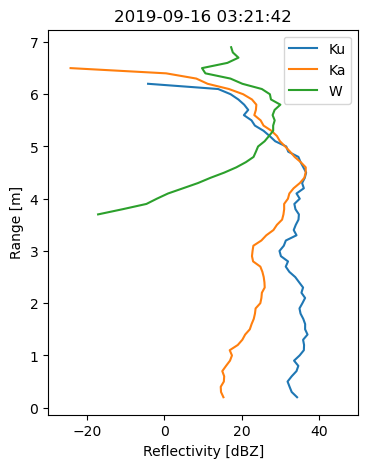

In [6]:
fig, ax = plt.subplots(figsize=(4, 5))
x_ku = ds['lores_zhh14'].sel(Time=time).isel(Time=0)
x_ka = ds['lores_zhh35'].sel(Time=time).isel(Time=0)
x_w = ds['hi2lo_z95n'].sel(Time=time).isel(Time=0)

y = ds.Alt_range.values
ax.plot(x_ku, y, label='Ku')
ax.plot(x_ka, y, label='Ka')
ax.plot(x_w, y, label='W')
ax.set_xlabel("Reflectivity [dBZ]")
ax.set_ylabel("Range [m]")
ax.set_xlim(-30, 50)
title = pd.to_datetime(ds.Time.sel(Time=time).values[0]).strftime('%Y-%m-%d %X')
ax.set_title(title)
ax.legend();

### Control experiment

Lets create a only one profile by taking the largest reflectivity above 4.4km 

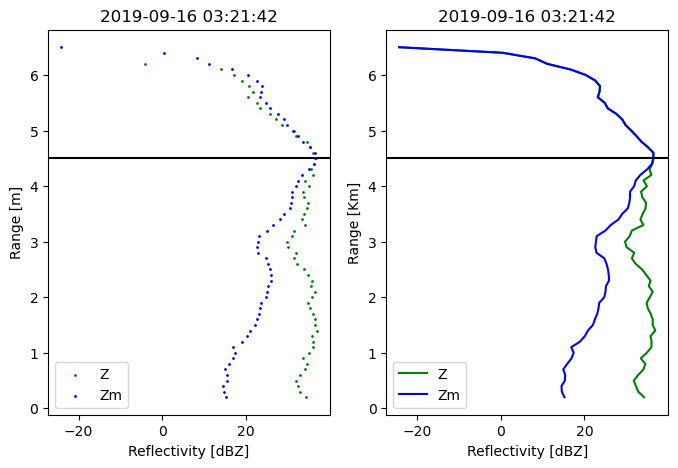

In [7]:
zm = ds['lores_zhh35'].sel(Time=time).isel(Time=0)
ze = ds['lores_zhh14'].sel(Time=time).isel(Time=0)
zet = xr.zeros_like(zm)
zet[zm.Alt_range <= 4.4] = ze.sel(Alt_range=slice(bottom, top))
zet[zm.Alt_range > 4.4] = zm.sel(Alt_range=slice(top + 0.1, 8))
zmt = xr.zeros_like(ze)
zmt[zet.Alt_range <= 4.4] = zm.sel(Alt_range=slice(bottom, top))
zmt[zet.Alt_range > 4.4] = zm.sel(Alt_range=slice(top + 0.1, 8))

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(8, 5))
y = ds.Alt_range.values
ax.scatter(ze, y, label='Z', s=1, c='green')
ax.scatter(zm, y, label='Zm', s=1, c='blue')
ax.set_xlabel("Reflectivity [dBZ]")
ax.set_ylabel("Range [m]")
ax.axhline(4.5, -25, 80, c='k')
title = pd.to_datetime(ds.Time.sel(Time='2019-09-16 03:21:42').values[0]).strftime('%Y-%m-%d %X')
ax.set_title(title)
ax.legend();

ax1.plot(zet, y, label='Z', c='green')
ax1.plot(zmt, y, label='Zm', c='blue')
ax1.set_xlabel("Reflectivity [dBZ]")
ax1.set_ylabel("Range [Km]")
ax1.axhline(4.5, -25, 80, c='k')
title = pd.to_datetime(ds.Time.sel(Time='2019-09-16 03:21:42').values[0]).strftime('%Y-%m-%d %X')
ax1.set_title(title)
ax1.legend();


## Attenuation PDE

Attenuation is decribe as follows
$$
Z_m  = Z * e^{-0.2ln(10)\int_{0}^{r} k(s)ds}
 \ \ \ \ \ \                  (1)
$$

Hitschfeld and Bordan (1954) suggest that the attenuation can be related to reflectivity using a power-law relationship

$$ 
k = \alpha Z^\beta
 \ \ \ \ \ \ \ (2)
$$ 

#### Attenuation differential equation

substituting (2) into (1) and differentiating with respect to range $\left(d/dr\right)$ gives a first-order differential equation, 
 
$$
\frac{du}{dr} + u\beta \frac{d}{dr} [ln(Z_m)] + q\alpha = 0
 \ \ \ \  \ \ (3)
$$

Where $$u=Z^{-\beta}$$ 
$$q=0.2ln(10)\beta$$

#### Initial conditions

$$
Z(r) = Z_m
$$

#### Boundary condition

$$
Z(r=0) = Z_m(r=0)
$$

$$
Z(r=Surface) = Z_m(Surface_{No \ rain})
$$
The last one is related to the Sea-Surface Reference Technique (SRT)

#### Analytical solution
The analytical solution for this first order differential equation is

$$
Z = \frac{Z_m}{\left[1 - qS(r)\right]^{1/\beta}}
\ \ \ \  \ \ (4)
$$

$S(r)$ is given by

$$
S(r) = \int_{0}^{r}\alpha(s)Z_m^{\beta}(s)ds
$$

## Neural Net

In [8]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(1, 30),
            nn.Hardswish(),
            nn.Linear(30, 50),
            nn.Hardswish(),
            nn.Linear(50, 50),
            nn.Hardswish(),
            nn.Linear(50, 50),
            nn.Hardswish(),
            nn.Linear(50, 50),
            nn.Hardswish(),
            nn.Linear(50, 30),
            nn.Hardswish(),
            nn.Linear(30, 20),
            nn.Hardswish(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)


def np2th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float32).to(device).reshape(n_samples, -1)

In [9]:
class LinearNN(nn.Module):
    def __init__(
            self,
            num_inputs: int = 1,
            num_layers: int = 1,
            num_neurons: int = 5,
            act: nn.Module = nn.Tanh(),
    ) -> None:
        """Basic neural network architecture with linear layers

        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()

        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # output layer
        layers.append(nn.Linear(num_neurons, 1))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()

In [10]:
class Net:
    def __init__(self, dr, rmin, rmax, zm_i, z_surf, epochs, alpha=5.47e-3, beta=0.691, loss=nn.MSELoss(),
                 lr=1e-3) -> None:
        self.model = LinearNN(num_inputs=1, num_layers=2, num_neurons=128, act=nn.Hardswish()).to(device)
        self.rmin = rmin
        self.rmax = rmax
        self.dr = dr
        self.alpha = torch.tensor(alpha, requires_grad=True)
        self.zmi = zm_i
        self.zm = np2th(zm_i).requires_grad_(True).to(device)
        self.beta = torch.tensor(beta)
        self.iter = 0
        self.epochs = epochs
        self.loss = loss
        self.zs = z_surf
        self.q = 0.2 * torch.log(torch.tensor(10)) * self.beta
        self.lr = lr

        # comp. domain
        self.r = torch.arange(self.rmin, self.rmax + self.dr, self.dr,
                              dtype=torch.float32).view(-1, 1).requires_grad_(True).to(device)

        # Train data
        self.x_train = self.r

        # Initial condition Z along the profile is equal to Ze
        y_ic = np2th(zm_i)
        self.y_train = y_ic.requires_grad_(True).to(device)

        self.adam = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=self.lr,
        )

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # data loss
        y_pred = self.model(self.x_train)
        loss_data = self.loss(y_pred, self.y_train)

        y_bc1 = self.model(self.x_train[0])
        loss_bc1 = torch.mean((y_bc1 - torch.tensor([self.zs]).to(device)) ** 2)
        y_bc2 = self.model(self.x_train[-1])
        loss_bc2 = torch.mean((y_bc2 - torch.tensor([self.zm[-1]]).to(device)) ** 2)

        u = self.model(self.x_train) ** - self.beta
        u = torch.tensor(u, requires_grad=True)
        du_dr = torch.autograd.grad(
            u,
            self.r,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
            allow_unused=True,
            materialize_grads=True

        )[0]

        dlnZm_dr = np2th(np.gradient(np.log(self.zmi), self.dr))

        # PDE loss
        loss_pde = du_dr + u * self.beta * dlnZm_dr + self.alpha * self.q
        loss_pde = torch.mean(loss_pde ** 2)

        # total loss
        loss = loss_pde + loss_bc1 + loss_bc2 #+ loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter + 1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epochs):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [11]:
zm = ds['lores_zhh35'].sel(Time=time).isel(Time=0)
ze = ds['lores_zhh14'].sel(Time=time).isel(Time=0)
zet = xr.zeros_like(zm)
zet[zm.Alt_range <= 4.4] = ze.sel(Alt_range=slice(bottom, top))
zet[zm.Alt_range > 4.4] = zm.sel(Alt_range=slice(top + 0.1, 8))
zmt = xr.zeros_like(ze)
zmt[zet.Alt_range <= 4.4] = zm.sel(Alt_range=slice(bottom, top))
zmt[zet.Alt_range > 4.4] = zm.sel(Alt_range=slice(top + 0.1, 8))
zmi = zm.sel(Alt_range=slice(bottom, top)).values
zs = ze.sel(Alt_range=slice(bottom, top)).values[0]
zt = zm.sel(Alt_range=slice(bottom, top)).values[-1]
net = Net(dr=0.1, rmin=bottom, rmax=top, zm_i=zmi, z_surf=zs, lr=1e-3, epochs=1000)

In [12]:
net.train()


0 nan
100 0.9086804284932579
200 0.000543556643915183
300 0.0005162196126734031
400 0.0005162194150620397
500 0.0005162194150620397
600 0.0005162194150620397
700 0.0005162194150620397
800 0.0005162194211774895
900 0.0005162194150620397
1000 0.0005162194150620397


In [13]:
net.model.eval()

LinearNN(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Hardswish()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Hardswish()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [14]:
r = torch.arange(0.2, 4.4 + 0.1, 0.1, dtype=torch.float32).view(-1, 1)
r = r.to(net.r.device)
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(r)
    y_pred = y_pred.cpu().numpy()
print(torch.seed())

18337048283880917101


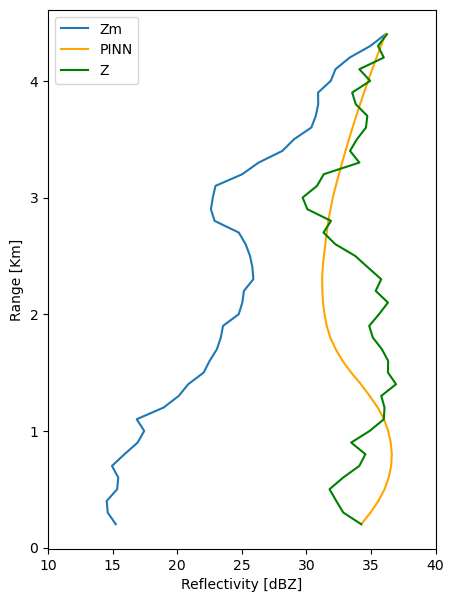

1


In [15]:
fig, ax = plt.subplots(figsize=(5, 7))
ax.plot(zmi, ds.Alt_range.sel(Alt_range=slice(bottom, top)).values,  label='Zm')
ax.plot(y_pred, r.cpu().numpy(), label='PINN', c='orange')
ax.plot(ze.sel(Alt_range=slice(bottom, top)).values, ds.Alt_range.sel(Alt_range=slice(bottom, top)).values,
            label="Z", c='green')
ax.set_ylabel("Range [Km]")
ax.set_xlabel("Reflectivity [dBZ]")
ax.set_xlim(10, 40)
ax.legend()
plt.show()
print(1)